In [1]:
import scipy.constants as SI
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%load_ext autoreload
%autoreload 2

In [2]:
#SI.constants
Energy = 4735
Ee = Energy * 1e9*SI.e
e = SI.e
me = SI.m_e
re = SI.physical_constants['classical electron radius'][0]

#Plasma parameters
n0 = 7e21 #m⁻³
L_plasma = 300 #m

wp = np.sqrt(n0*e**2/me/SI.epsilon_0)
kp = wp/SI.c
E0 = me*SI.c*wp/e
Ez = 6e9 #V/m
tau_r = 2*re/3/SI.c

K = kp/ np.sqrt(2)
A = tau_r * SI.c**2 * K**2
B = SI.c**2 * K**2
C = wp*Ez/E0
D = tau_r * SI.c**2 * K**4

#Initial gamma
gamma0 = Ee/me/(SI.c**2)
print(gamma0)

#Beam parameters
beta_matched = np.sqrt(2*gamma0)/kp
lambda_beta = 2*np.pi*beta_matched

k_beta = 2*np.pi/lambda_beta
emittance_norm = 160e-6 # m rad

sig_x = np.sqrt(beta_matched*emittance_norm/gamma0)

sig_xp = np.sqrt(1/beta_matched * emittance_norm/gamma0)
z0 = 0 # m
#For saving figures
actual = 'actual'
directory = f'd_gamma_{actual}_500GeV/'
save = False

9266163.85422229


In [3]:
T = L_plasma/SI.c
n_per_beta = 10000
n = round(L_plasma/lambda_beta * n_per_beta)
t, dt = np.linspace(0,T,n, retstep = True)
t_span = (0,T)

def d_gamma(x, y, gamma):
    return C - D*gamma**2*(x**2 + y**2)

def ddx(x, y, gamma):
    # x = [x,vx], same for y
    return -(C/gamma + A)*x[1] - B/gamma*x[0], -(C/gamma + A)*y[1] - B/gamma*y[0]
    

def oscillator2d(t, x):
    # x= [x,v_x, y, vy, gamma, z ,v_z]
    x_, vx_, y_, vy_, gamma_, z_, vz_ = x
    
    a_x = -(C/gamma_ + A)*vx_ - B/gamma_*x_
    a_y = -(C/gamma_ + A)*vy_ - B/gamma_*y_
    
    d_gamma = C - D*gamma_**2*(x_**2 + y_**2)
    
    v_z = np.sqrt(SI.c**2 - vx_**2 -vy_**2)
    a_z = 0

    #Set energy gain to energy loss
    #d_gamma = analytic_larmor(t, gamma_, rx, ry, phi, delta)/me/SI.c**2
    #d_gamma = 0
    return np.array([vx_, a_x, vy_, a_y, d_gamma, v_z, a_z])

def av_radiated_power(delta, gamma, k_beta, rx, ry):
    W = 1/SI.c * e**2/6/np.pi/SI.epsilon_0 * 1/SI.c**3 * ((gamma*k_beta*SI.c)**4 * \
        1/2 * (rx**2 + ry**2) + (gamma*k_beta)**6 * SI.c**4 * (1/4*rx**2 * ry**2 * np.cos(2*delta) + 1/8 * (rx**4 + ry**4)))
    return W

#Calculate the analytical mean energy loss
def mean_larmor(gamma, rx, ry):
    k_beta = kp/np.sqrt(2*gamma)
    scale = np.power(gamma/gamma0, -1/4)
    
    return e**2*SI.c/12/np.pi/SI.epsilon_0*(gamma*k_beta)**4*\
    ((scale*rx)**2+(scale*ry)**2)

#Calculate the analytical energy loss
def analytic_larmor(t, gamma, rx, ry, phi, delta):
    k_beta = kp/np.sqrt(2*gamma)
    scale = np.power(gamma/gamma0, -1/4)
    
    return e**2*SI.c/6/np.pi/SI.epsilon_0*(gamma*k_beta)**4*\
    (np.cos(k_beta*SI.c*t + phi)**2*(scale*rx)**2\
     + np.cos(k_beta*SI.c*t + delta)**2*(scale*ry)**2)   

In [4]:
def plot_oscillations(func, sysinit, t_span, t_eval, rx, ry, phi, delta):
    solution = solve_ivp(fun = func, y0 = sysinit, method='RK45', t_span = t_span, t_eval = t_eval)
    #Extract solution values
    x_ivp = solution.y[0,:]
    vx_ivp = solution.y[1,:]
    y_ivp = solution.y[2,:]
    vy_ivp = solution.y[3,:]
    
    gamma_ivp = solution.y[4,:]
    t_ivp = solution.t
    z_ivp = solution.y[5,:]
    vz_ivp = solution.y[6,:]
    energy_ivp = gamma_ivp*me*SI.c**2
    
    #Vectors to store new calculated values
    total_energy_change = np.zeros(n-1)
    P = np.zeros(n-1) #Energy loss per meter
    z = np.zeros(n-1)
    energy_change = np.zeros(n-1)
    energy_gain_per_m = np.zeros(n-1)
    
    for i in range(n-1):
        #Calculate the acceleration from differences in velocities
        ax = (vx_ivp[i+1] - vx_ivp[i])/dt
        ay = (vy_ivp[i+1] - vy_ivp[i])/dt
        az = (vz_ivp[i+1] - vz_ivp[i])/dt

        #Calculate a new z_array to use for plots (acceleration has n-1 points)
        z[i] = z_ivp[i]
        
        a = np.array([ax, ay, az])

        #Calculate gamma⁴ * (dbeta/dt)²
        A1 = gamma_ivp[i]**4 * 1/SI.c**2 * np.dot(a,a)
        #Calculate energy radiated PER METER from actual larmor formula
        P[i] = 1/SI.c * e**2/6/np.pi/SI.epsilon_0 * 1/SI.c * A1 # J*m⁻¹

        #Calculate the actual energy-differences from the simulation
        energy_gain_per_m[i] = 1/SI.c * wp*Ez/E0* SI.m_e*SI.c**2
        total_energy_change[i] = 1/SI.c * (energy_ivp[i+1]-energy_ivp[i])/dt # J*m⁻¹
        
    #Calculate the analytical values
    analytic_P = 1/SI.c * analytic_larmor(t_ivp, gamma_ivp, rx, ry, phi, delta)
    mean_analytic_P = 1/SI.c * mean_larmor(gamma_ivp, rx, ry)
    
    #Plot
    fig, ax = plt.subplots(3,2, figsize=(12,10))
    fig.suptitle('Evolution of Beam Parameters')
    # Plot x and y trajectories
    ax[0,0].plot(z_ivp,x_ivp*1e6)
    ax[0,0].grid()
    ax[0,0].set_ylabel('x (um)')
    ax[0,0].set_xlabel('s (m)')
    
    ax[0, 1].plot(z_ivp,y_ivp*1e6)
    ax[0, 1].grid()
    ax[0, 1].set_ylabel('y (um)')
    ax[0, 1].set_xlabel('s (m)')

    #Plot velocities
    ax[1, 0].plot(z_ivp,vx_ivp, label = 'vx')
    ax[1, 0].plot(z_ivp,vy_ivp, label = 'vy')
    ax[1, 0].grid()
    ax[1, 0].set_ylabel('Transverse Velocities (m/s)')
    ax[1, 0].set_xlabel('s (m)')
    ax[1, 0].legend()

    #Plot calculated energy loss from larmor formula, and the 
    #analytical mean radiated power (per meter)
    #ax[1, 1].plot(z,(energy_gain_per_m - total_energy_change)/e*1e-9, label = 'simulated')
    ax[1, 1].plot(z,P/e*1e-9, label = 'Calculated From Coupled Equations')
    ax[1, 1].plot(z_ivp, mean_analytic_P/e*1e-9, label = 'Analytical Mean Radiated Power')
    ax[1, 1].grid()
    ax[1, 1].set_ylabel('Radiated Power (GeV/m)')
    ax[1, 1].set_xlabel('s (m)')
    ax[1, 1].legend()

    #Plot Energy evolution
    ax[2, 0].plot(z_ivp, gamma_ivp*me*SI.c**2/e*1e-9, label = 'Energy')
    #ax[2, 0].plot(z_ivp, Brutto_energy/e*1e-9, label = 'Brutto Energy Gain')
    ax[2, 0].grid()
    ax[2, 0].set_ylabel('Energy (GeV)')
    ax[2, 0].set_xlabel('s (m)')
    #ax[2, 0].legend()

    #Plot analytical values for larmor formula and mean of the larmor formula
    ax[2, 1].plot(z_ivp,analytic_P/e*1e-9, label = 'Simplified Larmor Formula')
    ax[2, 1].scatter(z_ivp, mean_analytic_P/e*1e-9, label = 'Analytical ' \
    + 'Mean Radiated Power', marker = 'H', c ='tab:orange')
    ax[2, 1].grid()
    ax[2, 1].set_ylabel('Analytic Radiated Power (GeV/m)')
    ax[2, 1].set_xlabel('s (m)')
    ax[2, 1].legend()
    return x_ivp, z_ivp, energy_ivp, fig, P, z

/home/daniel/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/daniel/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


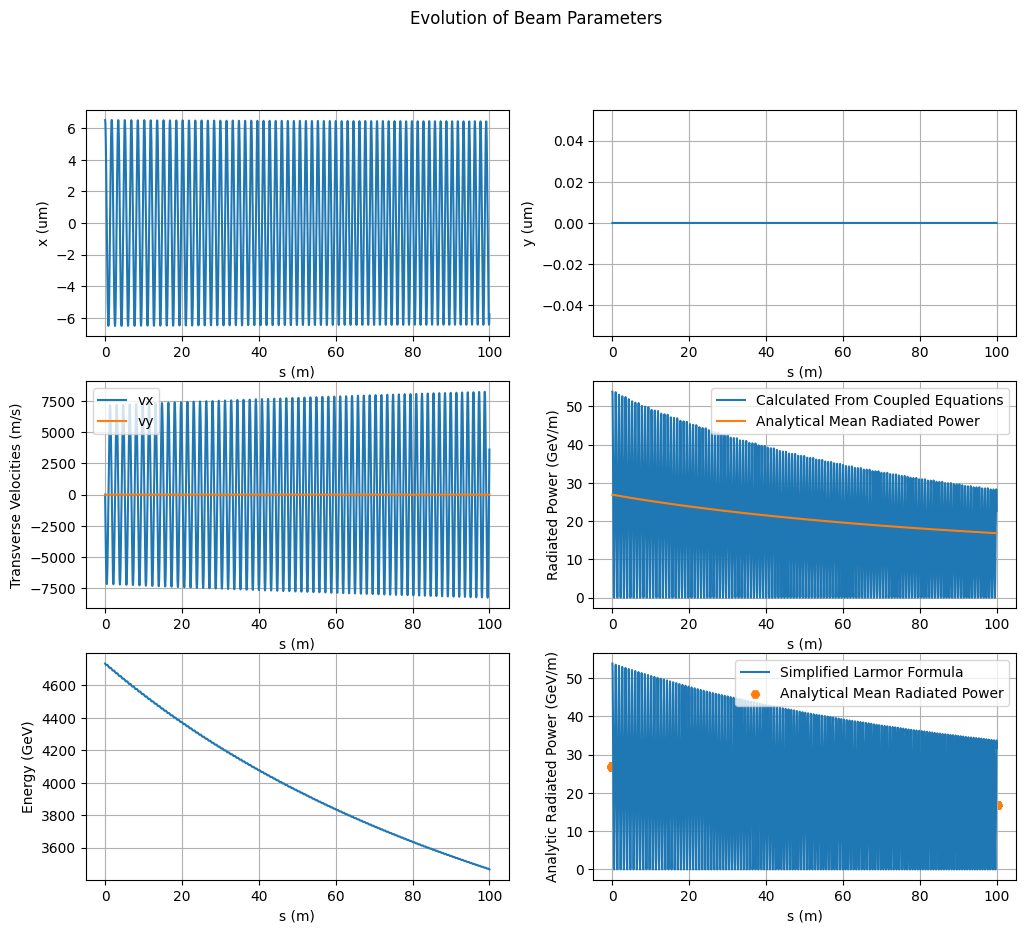

In [5]:
x0 = 3*sig_x# m
y0 = 0 # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s

sysinit2dx = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig, P, s = plot_oscillations(func = oscillator2d, sysinit = sysinit2dx, \
                                          t_span = t_span, t_eval = t,\
                                          rx = x0, ry = y0, phi = 0, delta =0)
if save:
    name = directory + f'{Energy}_GeV_single_particle_simulation_only_x_gamma_{actual}.png'
    fig.savefig(name)

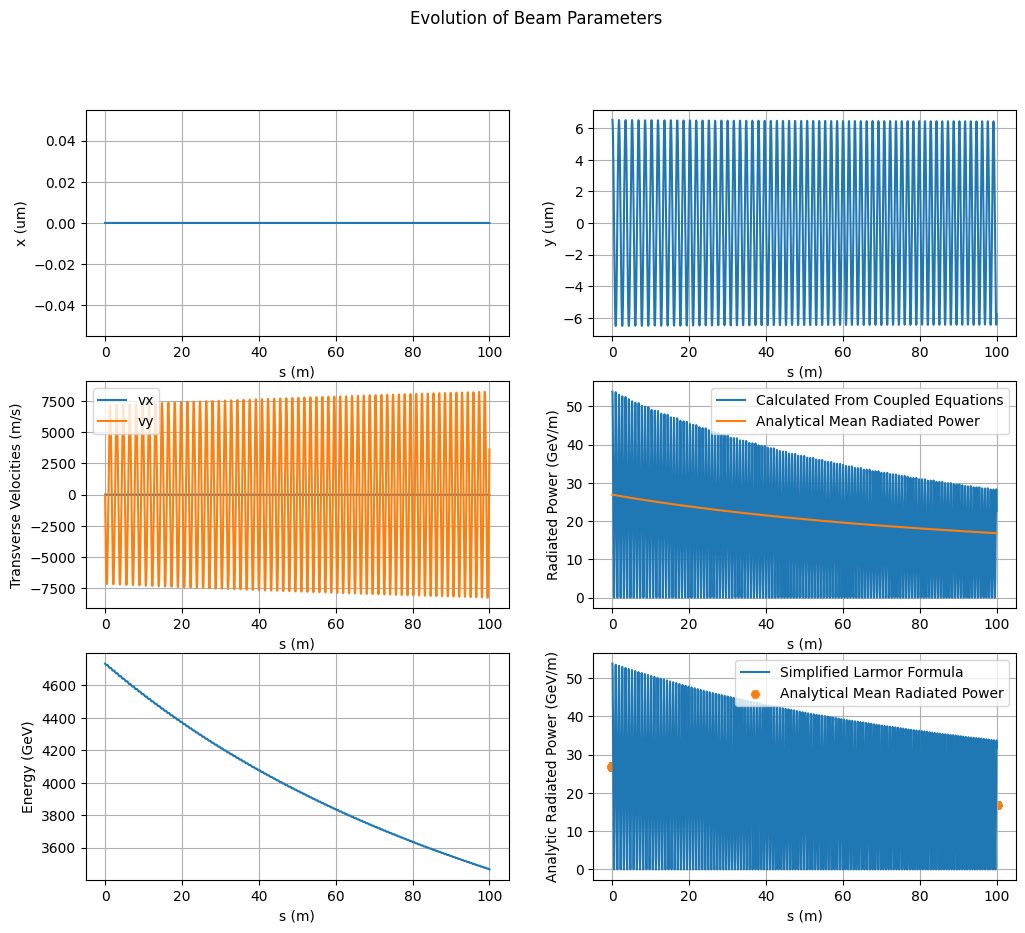

In [6]:
x0 = 0 # m
y0 = 3*sig_x  # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2dy = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig2, P, s = plot_oscillations(func = oscillator2d, sysinit = \
                                           sysinit2dy, t_span = t_span, t_eval = t,\
                                           rx = x0, ry = y0, phi = 0, delta =0)
if save:    
    name = directory + f'{Energy}_GeV_single_particle_simulation_only_y_gamma_{actual}.png'   
    fig2.savefig(name)

/home/daniel/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/daniel/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


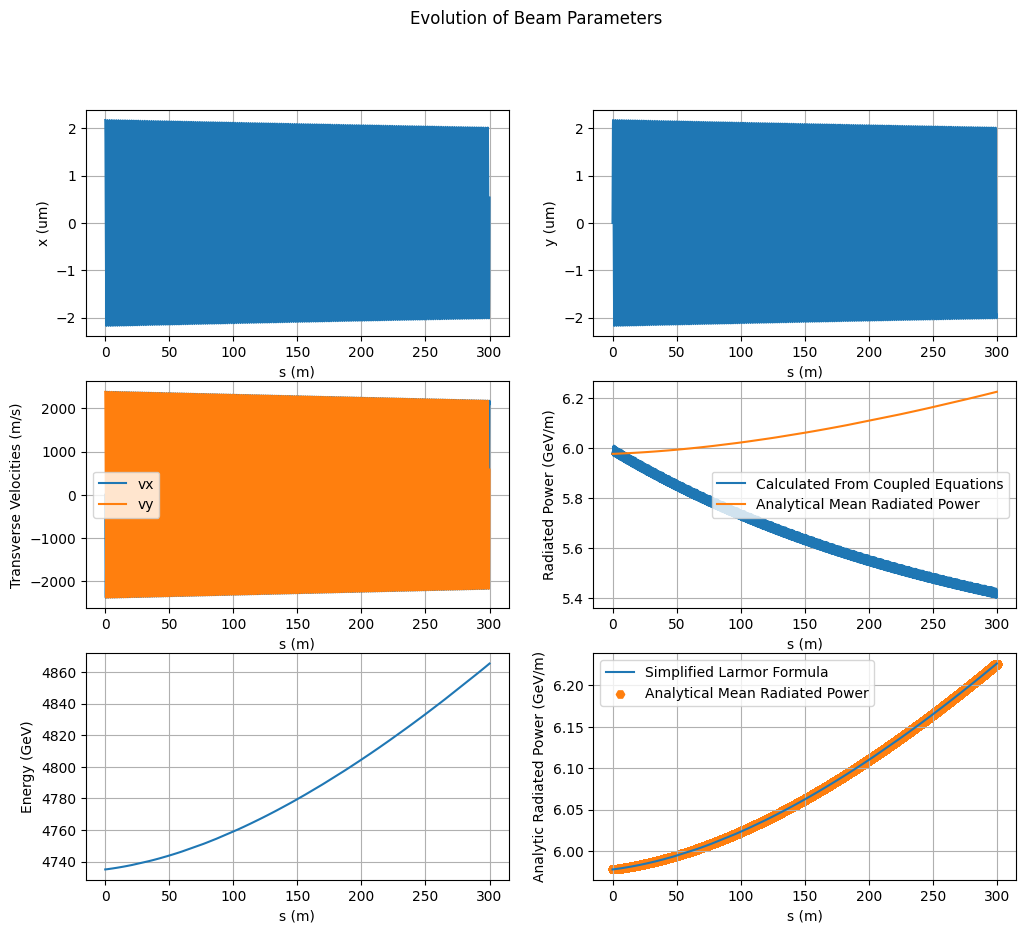

In [5]:
theta = np.pi/2
x0 = sig_x # m
y0 = 0 # m
ry = x0
x_dot0 = 0 # m/s
y_dot0 = sig_xp*SI.c # m/s
sysinit2d45 = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])


xs, zs, Es, fig3, P, s = plot_oscillations(func = oscillator2d, sysinit = sysinit2d45,\
                                           t_span = t_span, t_eval = t\
                                          , rx = x0, ry = ry, phi = 0, delta =-np.pi/2)
if save:   
    name = directory + f'{Energy}_GeV_single_particle_simulation_xy_out_of_phase_gamma_{actual}.png'
    fig3.savefig(name)

fig2 = plt.figure(figsize=(8,6))
plt.plot(z, energy_change*1e-9, label = 'analytic')
plt.plot(z,total_energy_change/e*1e-9, label = 'simulated')
plt.xlabel('z (m)')
plt.ylabel('P (GeV/m)')
plt.legend()

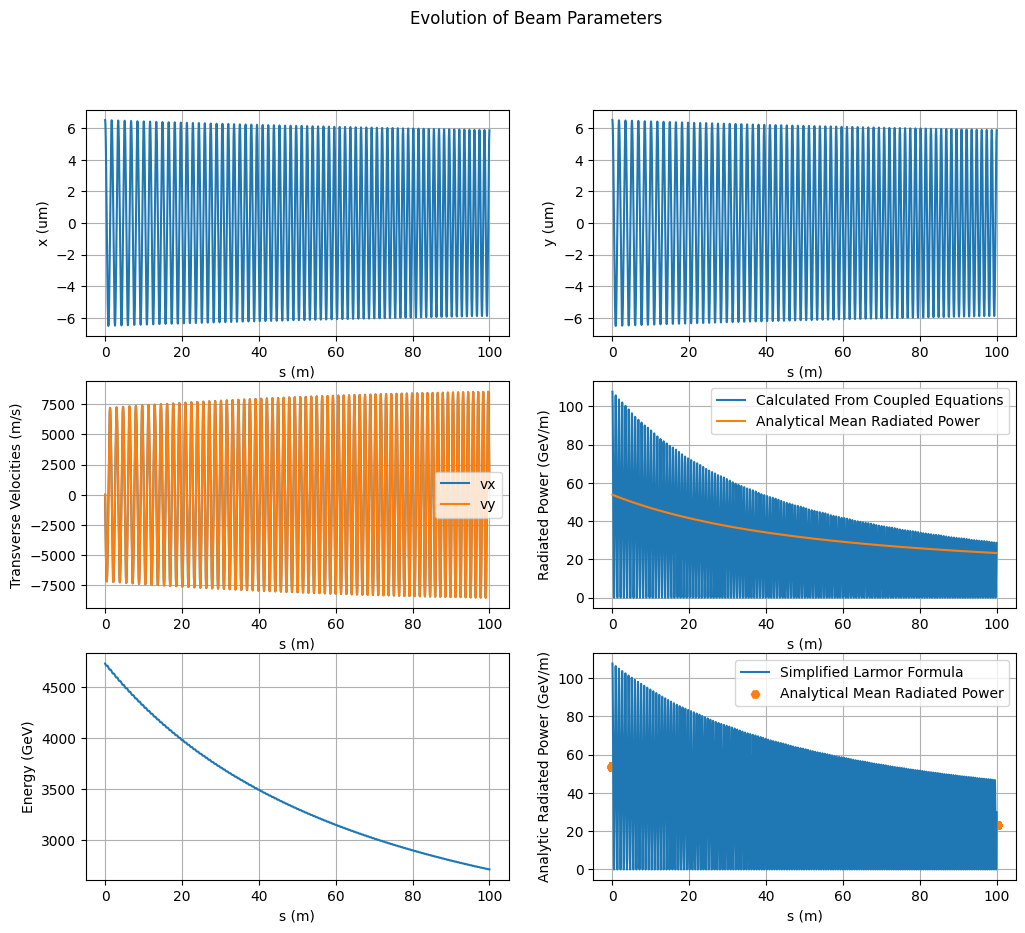

In [8]:
x0 = 3*sig_x # m
y0 = 3*sig_x # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2d45 = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig4, P, s = plot_oscillations(func = oscillator2d, sysinit = sysinit2d45,\
                                           t_span = t_span, t_eval = t\
                                          , rx = x0, ry = y0, phi = 0, delta =0)
if save: 
    name = directory + f'{Energy}_GeV_single_particle_simulation_xy_in_phase_gamma_{actual}.png'
    fig4.savefig(name)

In [9]:
print(1/SI.c*(SI.e**2/6/np.pi/SI.epsilon_0/SI.c**3 * (Ee/SI.m_e/SI.c**2)**4 * (3*sig_x*k_beta**2*SI.c**2)**2)/e*1e-9)

53.80065300465361


In [10]:
P_av = np.mean(P)
P_int = np.trapz(P, s)/L_plasma

W = av_radiated_power(np.pi/2, Ee/SI.m_e/SI.c**2, k_beta, x0, y0)
print(Ee/SI.m_e/SI.c**2)

print(P_int/SI.e*1e-9)
print(W/SI.e*1e-9)

9266163.85422229
26.600007640951755
53.80065300465358


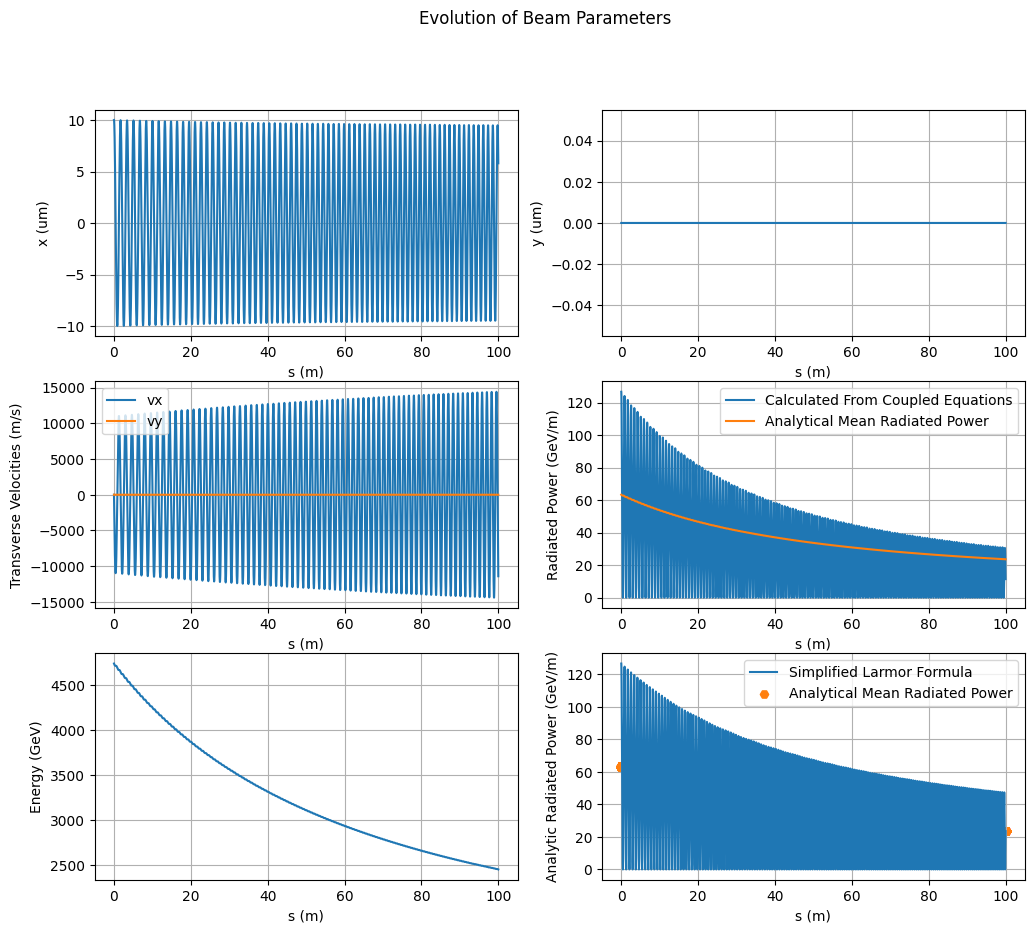

In [11]:
x0 = 10e-6 # m
y0 = 0 # m
z0 = 0 # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2dy = np.array([x0, x_dot0, y0, y_dot0, gamma0, z0, SI.c])

xs, zs, Es, fig2, P, s = plot_oscillations(func = oscillator2d, sysinit = \
                                           sysinit2dy, t_span = t_span, t_eval = t,\
                                           rx = x0, ry = y0, phi = 0, delta =0)

In [12]:
if save:
    fig2.savefig(f'single_particle_simulation_Evolution_of_beam_parameters_{(Energy)}GeV_\
    11m_inits_z{z0*1e6}_x{x0*1e6}_y{y0*1e6}\
    _xp{x_dot0/SI.c}_yp{y_dot0/SI.c}.png')

Text(0.5, 1.0, 'Energy loss due to radiation reaction for an initial energy of 4735 GeV')

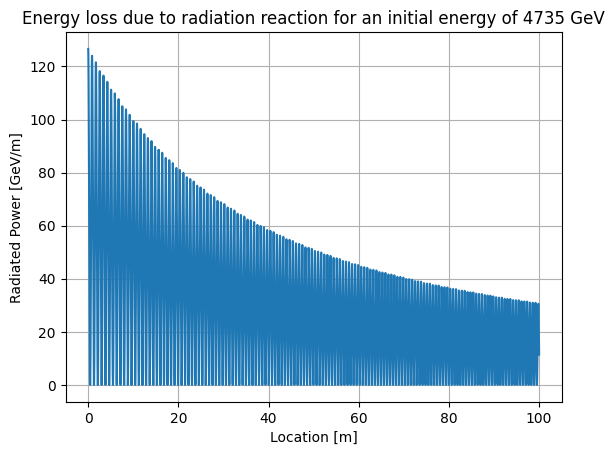

In [13]:
fig = plt.figure()
plt.plot(s, P/e*1e-9, label = 'Simulated Energy Difference')
plt.grid()
plt.xlabel('Location [m]')
plt.ylabel('Radiated Power [GeV/m]')
plt.title(f'Energy loss due to radiation reaction for an initial energy of {Energy} GeV')

In [14]:
#if save:
#fig.savefig(f'single_particle_simulation_Energy_loss_{(Energy)}GeV_\
#11m_inits_z{z0*1e6}_x{x0*1e6}_y{y0*1e6}\
#_xp{x_dot0/SI.c}_yp{y_dot0/SI.c}.png')

In [15]:
x0 = 10e-7 # m
y0 = 0 # m
z0 = 0 # m
x_dot0 = 0 # m/s
y_dot0 = 0 # m/s
sysinit2d = np.array([x0, x_dot0, y0, y_dot0, gamma0])

t, sol = lf.leapforg_integrator(t, sysinit2d, n0)
x = sol[0,:]
y = sol[2,:]
E = sol[4,:]*SI.m_e*SI.c**2 /SI.e / 1e9

NameError: name 'lf' is not defined

In [ ]:
print(x)

In [ ]:
plt.plot(t*SI.c, x)

In [ ]:
PS = 3.2e9 * SI.e
gamma = (7.5e12*SI.e)/SI.m_e/SI.c**2
k_beta = kp/np.sqrt(2*gamma)
Sum = PS*12*np.pi*SI.epsilon_0/SI.e**2/(gamma*k_beta)**4

In [ ]:
print(Sum)

In [ ]:
print(np.sqrt(Sum))